# Packege & Env.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

print('INFO. : PyTorch Version - ', torch.__version__)
print('INFO. : Number of GPUs - ', torch.cuda.device_count())

GPUNUM = torch.cuda.device_count()
if GPUNUM == 0:
    torch.cuda.is_available = lambda : False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('INFO. : This training job does not use GPU for training.')
else :
    print('INFO. : This training job uses GPU for training.')


import pandas as pd

INFO. : PyTorch Version -  2.2.1+cu121
INFO. : Number of GPUs -  0
INFO. : This training job does not use GPU for training.


# Setting.

In [ ]:
summary_df = {}
summary_idx= ['Average Train Loss', 'Test Loss', 'Test Acc']
summary_fl_iid={}
summary_fl_noniid={}
summary_centralization={}

# Class.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def client_update(client_model, optimizer, train_loader, epoch=5):
    model.train()
    total_samples = 0
    correct_predictions = 0
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            if GPUNUM == 0:
                data, target = data.cpu(), target.cpu()
            else :
                data, target = data.cuda(), target.cuda()
            # data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            # Calculate accuracy within each batch
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

    # Calculate overall accuracy after all epochs
    acc = correct_predictions / total_samples
    return loss.item(),acc

def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def test(global_model, test_loader):
    global_model.eval()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if GPUNUM == 0:
                data, target = data.cpu(), target.cpu()
            else :
                data, target = data.cuda(), target.cuda()
            # data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

# IID Case.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 60821795.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 36344342.58it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 44184788.06it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3039331.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



0-th round
average train loss 0.824 | test loss 0.651 | test acc: 0.805
1-th round
average train loss 0.245 | test loss 0.303 | test acc: 0.913
2-th round
average train loss 0.0606 | test loss 0.223 | test acc: 0.934
3-th round
average train loss 0.0334 | test loss 0.193 | test acc: 0.947
4-th round
average train loss 0.0134 | test loss 0.164 | test acc: 0.955
INFO. Summary.
                    0-th round  1-th round  2-th round  3-th round  4-th round
Average Train Loss    0.823798    0.244643    0.060557    0.033372    0.013370
Test Loss             0.650846    0.302743    0.222621    0.192596    0.163995
Test Acc              0.805500    0.912900    0.934300    0.946600    0.955000
Trainig Complete.


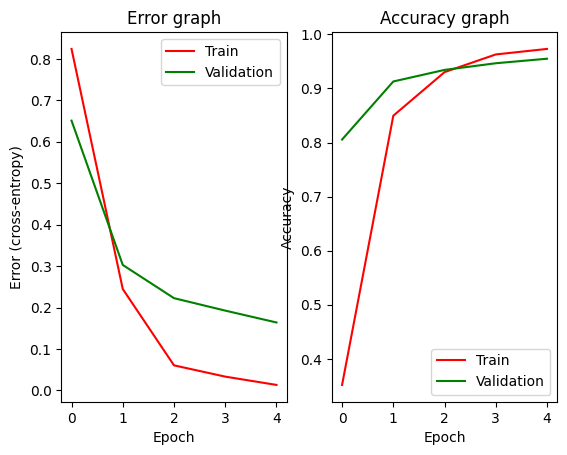

In [ ]:
# IID case: all the clients have images of all the classes

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 5
epochs = 5
batch_size = 32

# Log.
case_summary_df = {}

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

if GPUNUM == 0:
    global_model = Net().cpu()
    client_models = [Net().cpu() for _ in range(num_selected)]
else:
    global_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_selected)]

# global_model = Net().cuda()
# client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL
train_errors = []
train_acc = []
val_errors = []
val_acc = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    acc = 0
    for i in range(num_selected):
        total_loss,total_acc = client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        loss+=total_loss
        acc+=total_acc

    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, test_acc = test(global_model, test_loader)

    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, test_acc))
    # Save info log
    case_summary_df_tem = '%d-th round' % r
    case_summary_df_atl = loss / num_selected
    case_summary_df_tl = test_loss
    case_summary_df_ta = test_acc
    case_summary_df.update({case_summary_df_tem: [case_summary_df_atl, case_summary_df_tl, case_summary_df_ta]})
    # save error acc
    train_errors.append(loss/num_selected)
    train_acc.append(acc/num_selected)
    val_errors.append(test_loss)
    val_acc.append(test_acc)

# Save info log
case_summary = pd.DataFrame(data=case_summary_df, index=summary_idx)
print("INFO. Summary.")
print(case_summary)
summary_fl_iid = case_summary
print("Trainig Complete.")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error graph")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy graph")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

# NON-IID Case.

0-th round
average train loss 0.141 | test loss 2.45 | test acc: 0.197
1-th round
average train loss 0.01 | test loss 2.42 | test acc: 0.326
2-th round
average train loss 0.0387 | test loss 2.19 | test acc: 0.379
3-th round
average train loss 0.0422 | test loss 3.69 | test acc: 0.198
4-th round
average train loss 0.00974 | test loss 1.31 | test acc: 0.527
5-th round
average train loss 0.0126 | test loss 1.76 | test acc: 0.373
6-th round
average train loss 0.0171 | test loss 1.5 | test acc: 0.479
7-th round
average train loss 0.00421 | test loss 1.36 | test acc: 0.588
8-th round
average train loss 0.00152 | test loss 1.74 | test acc: 0.374
9-th round
average train loss 0.00191 | test loss 1.97 | test acc: 0.451
10-th round
average train loss 0.00388 | test loss 1.57 | test acc: 0.571
11-th round
average train loss 0.00224 | test loss 0.79 | test acc: 0.713
12-th round
average train loss 0.00762 | test loss 0.821 | test acc: 0.672
13-th round
average train loss 0.00236 | test loss 0.619 

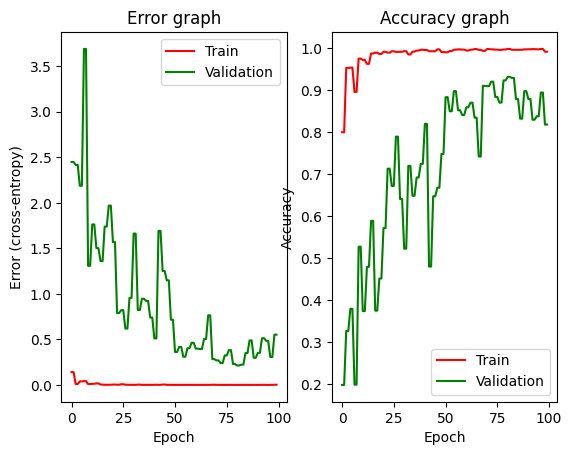

In [ ]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 5
num_rounds = 50
epochs = 5
batch_size = 32

# Log.
case_summary_df = {}

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers
if GPUNUM == 0:
    global_model = Net().cpu()
    client_models = [Net().cpu() for _ in range(num_selected)]
else:
    global_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_selected)]
# global_model = Net().cuda()
# client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL
train_errors = []
train_acc = []
val_errors = []
val_acc = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    acc = 0
    for i in range(num_selected):
        total_loss,total_acc = client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        loss+=total_loss
        acc+=total_acc

    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, test_acc = test(global_model, test_loader)

    train_errors.append(loss/num_selected)
    train_acc.append(acc/num_selected)
    val_errors.append(test_loss)
    val_acc.append(test_acc)

    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, test_acc))
    # Save info log
    case_summary_df_tem = '%d-th round' % r
    case_summary_df_atl = loss / num_selected
    case_summary_df_tl = test_loss
    case_summary_df_ta = test_acc
    case_summary_df.update({case_summary_df_tem: [case_summary_df_atl, case_summary_df_tl, case_summary_df_ta]})
    # save error acc
    train_errors.append(loss/num_selected)
    train_acc.append(acc/num_selected)
    val_errors.append(test_loss)
    val_acc.append(test_acc)

# Save info log
case_summary = pd.DataFrame(data=case_summary_df, index=summary_idx)
print("INFO. Summary")
print(case_summary)
summary_fl_noniid = case_summary
print("Trainig Complete.")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error graph")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy graph")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

# Local, Centralization Case.

0-th round
average train loss 0.023 | test loss 0.0229 | test acc: 0.241
1-th round
average train loss 0.0228 | test loss 0.0224 | test acc: 0.416
2-th round
average train loss 0.0149 | test loss 0.00522 | test acc: 0.848
3-th round
average train loss 0.00423 | test loss 0.00355 | test acc: 0.890
4-th round
average train loss 0.00333 | test loss 0.00314 | test acc: 0.902
5-th round
average train loss 0.00282 | test loss 0.00262 | test acc: 0.920
6-th round
average train loss 0.00244 | test loss 0.00231 | test acc: 0.928
7-th round
average train loss 0.00213 | test loss 0.00198 | test acc: 0.941
8-th round
average train loss 0.00188 | test loss 0.00188 | test acc: 0.944
9-th round
average train loss 0.00168 | test loss 0.0017 | test acc: 0.947
INFO. Summary.
                    0-th round  1-th round  2-th round  3-th round  \
Average Train Loss    0.022993    0.022781    0.014926    0.004234   
Test Loss             0.022939    0.022413    0.005216    0.003555   
Test Acc              

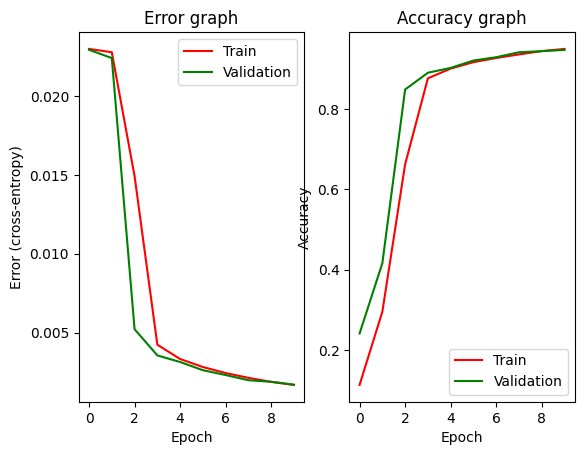

Test accuracy : 0.9519


In [ ]:
# Local, Centralization Case : Classic deep learning training method.

"""CNN MNIST.ipynb
Automatically generated by Colaboratory. Original file is located at ...
Reference :
 - https://colab.research.google.com/drive/14YB2h3vxvxOanJc1yDDEqw0O4atiz7Rm
 - https://github.com/dandiws/CNN-MNIST-pytorch/blob/master/cnn_mnist.py
"""

# Hyperparameters

batch_size = 100
validation_split = .1
shuffle_dataset = True
random_seed= 2
num_rounds = 10

# Log.
case_summary_df = {}

# Creating decentralized datasets
train_ds = datasets.MNIST('./data',train=True,download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Creating data indices for training and validation splits:
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader( datasets.MNIST('./data',train=False,download=True,
    transform=transforms.Compose([transforms.ToTensor()])),batch_size=batch_size,shuffle=True)

if GPUNUM == 0:
    model = Net().cpu()
else:
    model = Net().cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(validation_loader)*batch_size

for r in range(num_rounds):
  total_loss = 0
  total_acc = 0
  c = 0
  for images,labels in train_loader:
    if GPUNUM == 0:
      images = images.cpu()
      labels = labels.cpu()
    else:
      images = images.cuda()
      labels = labels.cuda()

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1

  # Validation
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in validation_loader:
    if GPUNUM == 0:
      images = images.cpu()
      labels = labels.cpu()
    else:
      images = images.cuda()
      labels = labels.cuda()
    output = model(images)
    loss = criterion(output,labels)

    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1

  print('%d-th round' % r)
  print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (total_loss / n_train, total_loss_val/n_val, total_acc_val/n_val))
  # Save info log
  case_summary_df_tem = '%d-th round' % r
  case_summary_df_atl = (total_loss / n_train)
  case_summary_df_tl = total_loss_val/n_val
  case_summary_df_ta = total_acc_val/n_val
  case_summary_df.update({case_summary_df_tem: [case_summary_df_atl, case_summary_df_tl, case_summary_df_ta]})
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)

# Save info log
# print(case_summary_df)
# print(type(case_summary_df))
case_summary = pd.DataFrame(data=case_summary_df, index=summary_idx)
print("INFO. Summary.")
print(case_summary)
summary_centralization = case_summary
print("Trainig Complete.")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error graph")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy graph")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  if GPUNUM == 0:
    images = images.cpu()
    labels = labels.cpu()
  else:
    images = images.cuda()
    labels = labels.cuda()
  # images = images.cuda()
  # labels = labels.cuda()
  output = model(images)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))

# Summary.

In [ ]:
print('FL IID.')
print(summary_fl_iid)
print('FL IID. End.')
print('FL Non-IID.')
print(summary_fl_noniid)
print('FL Non-IID. End.')
print('Centralization')
print(summary_centralization)
print('Centralization End.')

FL IID.
                    0-th round  1-th round  2-th round  3-th round  4-th round
Average Train Loss    0.823798    0.244643    0.060557    0.033372    0.013370
Test Loss             0.650846    0.302743    0.222621    0.192596    0.163995
Test Acc              0.805500    0.912900    0.934300    0.946600    0.955000
FL IID. End.
FL Non-IID.
                    0-th round  1-th round  2-th round  3-th round  \
Average Train Loss    0.140981    0.010024    0.038714    0.042180   
Test Loss             2.448300    2.415522    2.186870    3.689567   
Test Acc              0.197300    0.325600    0.378700    0.198000   

                    4-th round  5-th round  6-th round  7-th round  \
Average Train Loss    0.009742    0.012597    0.017063    0.004209   
Test Loss             1.307827    1.762308    1.502256    1.358814   
Test Acc              0.526800    0.373300    0.478900    0.588300   

                    8-th round  9-th round  ...  40-th round  41-th round  \
Average Trai